## Installing Modules

In [1]:
!pip install spacy==3
!python -m spacy download en_core_web_sm
!pip install pytorch_lightning torchmetrics tableprint
!python -m spacy download de_core_news_sm


2021-06-18 04:56:35.371444: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
2021-06-18 04:56:44.121211: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
✔ Download and installation successful
You can now load the package via spacy.load('de_core_news_sm')


## Imports

In [2]:
# Import Library
import random
import torch, torchtext
from torchtext.legacy import data 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


import pandas as pd
import sys, os, pickle
import numpy as np
import math
import matplotlib.pyplot  as plt

import spacy

import pytorch_lightning as pl
import torchmetrics

from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix
import tableprint as tp

import collections

# Manual Seed
SEED = 43
torch.manual_seed(SEED)

## Loading Data

I downloaded the original files from github using wget. This could also have been done using the Multi30k dataset, but I chose the former.

In [3]:
!wget https://raw.githubusercontent.com/multi30k/dataset/master/data/task1/raw/train.de.gz
!wget https://raw.githubusercontent.com/multi30k/dataset/master/data/task1/raw/train.en.gz
!wget https://raw.githubusercontent.com/multi30k/dataset/master/data/task1/raw/val.de.gz
!wget https://raw.githubusercontent.com/multi30k/dataset/master/data/task1/raw/val.en.gz

--2021-06-18 04:56:51--  https://raw.githubusercontent.com/multi30k/dataset/master/data/task1/raw/train.de.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 637044 (622K) [application/octet-stream]
Saving to: ‘train.de.gz’

train.de.gz         100%[===================>] 622.11K  --.-KB/s    in 0.02s   

2021-06-18 04:56:52 (34.1 MB/s) - ‘train.de.gz’ saved [637044/637044]

--2021-06-18 04:56:52--  https://raw.githubusercontent.com/multi30k/dataset/master/data/task1/raw/train.en.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5

In [4]:
!gunzip val.en.gz
!gunzip val.de.gz
!gunzip train.en.gz
!gunzip train.de.gz

gzip: val.en already exists; do you wish to overwrite (y or n)? y
gzip: val.de already exists; do you wish to overwrite (y or n)? y
gzip: train.en already exists; do you wish to overwrite (y or n)? ^C
gzip: train.de already exists; do you wish to overwrite (y or n)? ^C


In [5]:
train_df_src = pd.read_csv('train.en', sep="\t", encoding="utf8", header=None, names=['sentence'])
train_df_trg = pd.read_csv('train.de', sep="\t", encoding="utf8", header=None, names=['sentence'])
test_df_src = pd.read_csv('val.en', sep="\t", encoding="utf8", header=None, names=['sentence'])
test_df_trg = pd.read_csv('val.de', sep="\t", encoding="utf8", header=None, names=['sentence'])
train_df_src.head()

,sentence
0,"Two young, White males are outside near many b..."
1,Several men in hard hats are operating a giant...
2,A little girl climbing into a wooden playhouse.
3,A man in a blue shirt is standing on a ladder ...
4,Two men are at the stove preparing food.


In [6]:
train_df = pd.concat([train_df_src, train_df_trg], axis=1)
test_df = pd.concat([test_df_src, test_df_trg], axis=1)
train_df.columns = ['src', 'trg']
test_df.columns = ['src', 'trg']

In [7]:
train_df.head()

,src,trg
0,"Two young, White males are outside near many b...",Zwei junge weiße Männer sind im Freien in der ...
1,Several men in hard hats are operating a giant...,Mehrere Männer mit Schutzhelmen bedienen ein A...
2,A little girl climbing into a wooden playhouse.,Ein kleines Mädchen klettert in ein Spielhaus ...
3,A man in a blue shirt is standing on a ladder ...,Ein Mann in einem blauen Hemd steht auf einer ...
4,Two men are at the stove preparing food.,Zwei Männer stehen am Herd und bereiten Essen zu.


## Tokenization and Building Dataset/DataLoader

In [8]:
print(f'Number of Train Examples: {len(train_df)}')
print(f'Number of Test Examples: {len(test_df)}')

Number of Train Examples: 29000
Number of Test Examples: 1014


In [9]:
from torchtext.data.utils import get_tokenizer
src_tokenizer = get_tokenizer('spacy', language='en_core_web_sm')
trg_tokenizer = get_tokenizer('spacy', language='de_core_news_sm')

In [10]:
def build_vocab(df, tokenizer, **vocab_kwarg):
    
    token_freqs = collections.Counter()
    
    for index, row  in df.iterrows():
        tokens = tokenizer(row['sentence'])
        token_freqs.update(tokens)
        
    vocab = torchtext.vocab.Vocab(token_freqs)
    
    
    return vocab

In [11]:
src_vocab = build_vocab(train_df_src, src_tokenizer)
trg_vocab = build_vocab(train_df_trg, trg_tokenizer)

In [12]:
print('Size of src vocab : ', len(src_vocab.freqs))
print('Size of trg vocab : ', len(trg_vocab.freqs))

Size of src vocab :  10833
Size of trg vocab :  19210


In [13]:
def data_process(df):
    data = []
    for index, row in df.iterrows():
      src_tensor_ = torch.tensor([src_vocab[token] for token in src_tokenizer(row['src'])],
                                dtype=torch.long)
      trg_tensor_ = torch.tensor([trg_vocab[token] for token in trg_tokenizer(row['trg'])],
                                dtype=torch.long)
      data.append((src_tensor_, trg_tensor_))
    return data

train_dataset = data_process(train_df)
# val_dataset = data_process(val_df)
test_dataset = data_process(test_df)

In [14]:
PAD_IDX = src_vocab['<pad>']
print(PAD_IDX)

1


In [15]:
class Collator:
    def __init__(self, pad_idx):
        
        self.pad_idx = pad_idx
        
    def collate(self, batch):
        src_batch, trg_batch = [], []
        for src_item, trg_item in batch:
          src_batch.append(torch.cat([src_item], dim=0))
          trg_batch.append(torch.cat([trg_item], dim=0))
        src_batch = nn.utils.rnn.pad_sequence(src_batch, padding_value=self.pad_idx, batch_first=False)
        trg_batch = nn.utils.rnn.pad_sequence(trg_batch, padding_value=self.pad_idx, batch_first=False)

        return src_batch, trg_batch

In [16]:
collator = Collator(PAD_IDX)

In [17]:
batch_size = 32

train_loader = torch.utils.data.DataLoader(train_dataset,
                                            batch_size,
                                            shuffle = True,
                                            collate_fn = collator.collate,
                                            drop_last=True
                                          )

test_loader = torch.utils.data.DataLoader(test_dataset,
                                            batch_size,
                                            shuffle = False,
                                            collate_fn = collator.collate,
                                            drop_last=True
                                          )

Initializing GPU as the device

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Save the vocabulary for later use

In [19]:
with open('src_tokenizer.pkl', 'wb') as tokens: 
    pickle.dump(src_vocab.stoi, tokens)

with open('trg_tokenizer.pkl', 'wb') as tokens: 
    pickle.dump(trg_vocab.stoi, tokens)


## Defining Our Model

### Boilerplate code

In [20]:
class TL(pl.LightningModule):
    def __init__(self):
        super(TL, self).__init__()

        self.train_acc =  torch.tensor(0.)
        self.avg_train_loss = torch.tensor(0.)
        self.table_context = None
        

    def training_step(self, batch, batch_idx):
        src, trg = batch 
        output = self(src, trg)
        output_dim = output.shape[-1]
        output = output[1:].view(-1, output_dim)
        trg = trg[1:].view(-1)
        loss_train = self.loss(output, trg)
        return loss_train
    
    def validation_step(self, batch, batch_idx):
        src, trg = batch  
        output = self(src, trg, 0)
        output_dim = output.shape[-1]
        output = output[1:].view(-1, output_dim)
        trg = trg[1:].view(-1)
        loss_valid = self.loss(output, trg) 
        return {"loss": loss_valid}
    
    def training_epoch_end(self, outputs):
        self.avg_train_loss = torch.stack([x['loss'] for x in outputs]).mean()
    
    def validation_epoch_end(self, outputs):
        if trainer.running_sanity_check:
            return
        avg_valid_loss = torch.stack([x['loss'] for x in outputs]).mean()
        metrics = {'epoch': self.current_epoch+1, 'Train PPL': math.exp(self.avg_train_loss), 'Train Loss': self.avg_train_loss,  'Valid PPL': math.exp(avg_valid_loss), 'Valid Loss': avg_valid_loss}
        if self.table_context is None:
            self.table_context = tp.TableContext(headers=['epoch', 'Train PPL', 'Train Loss', 'Valid PPL', 'Valid Loss'])
            self.table_context.__enter__()
        self.table_context([self.current_epoch+1, math.exp(self.avg_train_loss.item()), self.avg_train_loss.item(), math.exp(avg_valid_loss.item()), avg_valid_loss.item()])
        self.logger.log_metrics(metrics)
        if self.current_epoch == self.trainer.max_epochs - 1:
            self.validation_end(outputs)
    
    def validation_end(self, outputs):
        self.table_context.__exit__()

### Encoder

In [21]:
class Encoder(pl.LightningModule):
    def __init__(self, input_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()
        
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        
        self.embedding = nn.Embedding(input_dim, emb_dim)  
        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout = dropout, batch_first=False)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src):
        embedded = self.dropout(self.embedding(src))
        output, (hidden,cell) = self.rnn(embedded)
        
        return hidden,cell

### Decoder

In [22]:
class Decoder(pl.LightningModule):
    def __init__(self, emb_dim, hid_dim, n_layers, dropout, output_dim):
        super().__init__()

        self.hid_dim = hid_dim
        self.n_layers = n_layers
        self.output_dim = output_dim
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout = dropout, batch_first=False) 
        self.fc_out = nn.Linear(hid_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, cell):
        input = input.unsqueeze(0) 
        embedded = self.dropout(self.embedding(input))
        output, (hidden,cell) = self.rnn(embedded, (hidden,cell))
        prediction = self.fc_out(output.squeeze(0))
        
        return prediction, hidden, cell

### Seq2Seq Model

In [23]:
# Define the model

class Seq2Seq(TL):
    def __init__(self, encoder, decoder, device):
        super(Seq2Seq, self).__init__()
        
        TRG_PAD_IDX = trg_vocab['<PAD>']
        self.loss = nn.CrossEntropyLoss(ignore_index=TRG_PAD_IDX)
        self.lr = 1e-3
        
        self.encoder = encoder
        self.decoder = decoder
        # self.device = device # Doesn't work in PyTorchLightning since it is already defined!

        assert encoder.hid_dim == decoder.hid_dim, "Hidden Dimensions of Encoder and Decoder must be equal"
        assert encoder.n_layers == decoder.n_layers, "Encoder and Decoder must have equal number of layers"
            
    def forward(self, src, trg, teacher_forcing_ratio = 0.5):
        
        batch_size = trg.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        
        hidden, cell = self.encoder(src)
                
        input = trg[0,:]
        
        for t in range(1, trg_len):
            
            output, hidden,cell = self.decoder(input, hidden, cell)
            
            outputs[t] = output
            
            teacher_force = random.random() < teacher_forcing_ratio
            
            top1 = output.argmax(1) 
            
            input = trg[t] if teacher_force else top1

        return outputs
    
    def configure_optimizers(self):
        optim = torch.optim.Adam(self.parameters())
        return optim

In [24]:
INPUT_DIM = len(src_vocab)
OUTPUT_DIM = len(trg_vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT, OUTPUT_DIM)

model = Seq2Seq(enc, dec, device).to(device)

## Model Checkpoint

This saves the best model (best => model with lowest val loss)

In [25]:
checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',
    dirpath='/content',
    filename='sst-{epoch:02d}-{val_loss:.2f}',
    mode='min'
)

In [26]:
!rm -rf csv_logs
csvlogger = CSVLogger('csv_logs', name='END2 Assign 7_2_TL', version=0)
trainer = pl.Trainer(max_epochs=20, num_sanity_val_steps=1, logger=csvlogger, gpus=1, callbacks=[checkpoint_callback], gradient_clip_val=1, gradient_clip_algorithm='norm')
trainer.fit(model, train_dataloader=train_loader, val_dataloaders=test_loader)
checkpoint_callback.best_model_path

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type             | Params
---------------------------------------------
0 | loss    | CrossEntropyLoss | 0     
1 | encoder | Encoder          | 6.5 M 
2 | decoder | Decoder          | 18.5 M
---------------------------------------------
24.9 M    Trainable params
0         Non-trainable params
24.9 M    Total params
99.617    Total estimated model params size (MB)


╭─────────────┬─────────────┬─────────────┬─────────────┬─────────────╮
│       epoch │   Train PPL │  Train Loss │   Valid PPL │  Valid Loss │
├─────────────┼─────────────┼─────────────┼─────────────┼─────────────┤
│           1 │      20.194 │      3.0054 │      17.243 │      2.8474 │


│           2 │      12.579 │       2.532 │      14.515 │      2.6752 │


│           3 │      10.336 │      2.3356 │      13.238 │      2.5831 │


│           4 │      8.6194 │       2.154 │      12.732 │      2.5441 │


│           5 │      7.5958 │      2.0276 │      11.899 │      2.4765 │


│           6 │      6.6891 │      1.9005 │      11.787 │       2.467 │


│           7 │      6.0315 │       1.797 │      11.185 │      2.4146 │


│           8 │      5.4878 │      1.7025 │      11.416 │       2.435 │


│           9 │      5.0367 │      1.6167 │      11.442 │      2.4373 │


│          10 │      4.6311 │      1.5328 │      11.426 │      2.4359 │


│          11 │      4.3749 │      1.4759 │      11.332 │      2.4276 │


│          12 │      4.0922 │      1.4091 │      11.794 │      2.4676 │


│          13 │       3.869 │       1.353 │       12.21 │      2.5022 │


│          14 │      3.6742 │      1.3013 │      12.088 │      2.4922 │


│          15 │      3.5334 │      1.2623 │      12.359 │      2.5143 │


│          16 │      3.3694 │      1.2147 │      12.429 │      2.5201 │


│          17 │      3.2581 │      1.1812 │      12.436 │      2.5206 │


│          18 │      3.1669 │      1.1528 │      12.548 │      2.5295 │


│          19 │      3.0316 │      1.1091 │      13.289 │      2.5869 │


│          20 │      2.9951 │       1.097 │       13.33 │      2.5901 │
╰─────────────┴─────────────┴─────────────┴─────────────┴─────────────╯



''

## Training Log

First define the optimizer and loss functions

In [27]:
root='./csv_logs/' + 'END2 Assign 7_2_TL' + '/'
dirlist = [ item for item in os.listdir(root) if os.path.isdir(os.path.join(root, item)) ]
metricfile = root + dirlist[-1:][0] + '/metrics.csv'
metrics = pd.read_csv(metricfile)

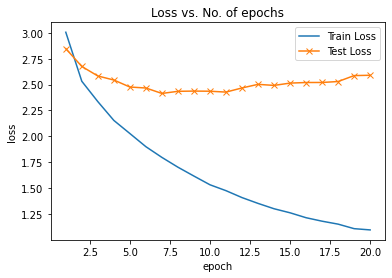

In [28]:
plt.plot(metrics['epoch'], metrics['Train Loss'], label="Train Loss")
plt.plot(metrics['epoch'], metrics['Valid Loss'], '-x', label="Test Loss")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.title('Loss vs. No. of epochs');

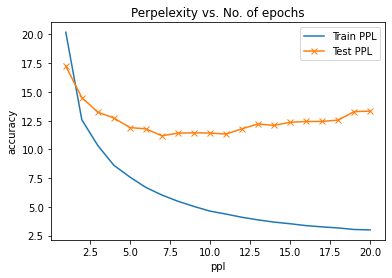

In [29]:
plt.plot(metrics['epoch'], metrics['Train PPL'], label="Train PPL")
plt.plot(metrics['epoch'], metrics['Valid PPL'], '-x', label="Test PPL")
plt.xlabel('ppl')
plt.ylabel('accuracy')
plt.legend()
plt.title('Perpelexity vs. No. of epochs');

## Inference on Random Samples from Test Data

In [30]:
model.to(device)
model.eval()

Seq2Seq(
  (loss): CrossEntropyLoss()
  (encoder): Encoder(
    (embedding): Embedding(10835, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(19212, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (fc_out): Linear(in_features=512, out_features=19212, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [31]:
for i in np.random.randint(0,len(test_df_src), 10):
  src_sent = test_df_src.iloc[i]['sentence']
  trg_sent = test_df_trg.iloc[i]['sentence']
  src_sent_tensor = torch.tensor([src_vocab[token] for token in src_tokenizer(src_sent)], dtype=torch.long).unsqueeze(1).to(device)   
  trg_sent_tensor = torch.tensor([trg_vocab[token] for token in trg_tokenizer(trg_sent)], dtype=torch.long).unsqueeze(1).to(device) 
  with torch.no_grad():
        output = model(src_sent_tensor, trg_sent_tensor, 1)
        # output_dim = output.shape[-1]
        # output = output[1:].view(-1, output_dim)
        out = output.squeeze(1)
        out = torch.argmax(out,dim=1)
        trans = []
        for c in out[1:]:
          trans.append(trg_vocab.itos[c])
        st = " ".join(trans)
        start = "\033[1m"
        end = "\033[0;0m"
        print(f'{start}Source Sentence: {end}{src_sent}')
        print(f'{start}Target Sentence: {end}{trg_sent}')
        print(f'{start}Translated Sentence: {end}{st}')
        print()

Source Sentence: A boy wearing a green shirt on a bicycle reflecting off a store window.
Target Sentence: Das Bild eines Jungen in einem grünen T-Shirt, der auf einem Fahrrad sitzt, spiegelt sich in einer Schaufensterscheibe.
Translated Sentence: Junge in grünen auf einem grünen Hemd auf der auf dem Dach ein auf während . . der Betonrampe .

Source Sentence: A woman is standing and wearing a green and yellow scarf.
Target Sentence: Eine stehende Frau trägt einen grün-gelben Schal.
Translated Sentence: Frau Frau in Pompoms blau-grünen Bikini und

Source Sentence: A large crowd stand watching with a large buildings in the background.
Target Sentence: Eine große Menschenmenge sieht mit großen Gebäuden im Hintergrund bei etwas zu.
Translated Sentence: große Menschenmenge steht sich einem großen , Hintergrund . einem . sehen

Source Sentence: A bunch of young adults stare in concentration at their computer monitors as they competitively game.
Target Sentence: Mehrere junge Erwachsene starre